TODO: 
- get better data, this is not realistic (predictions are too wild)
- build in exposure

# Intro

Goal: create a function that draws lift charts. 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import tweedie # for tweedie random sample

# Chart Summary

lift chart shows two lines: one for predicted and one for actual

first, the data is sorted by the predicted values

then, we sum up the actual and predicted values in a number of bins

cutoff points should be by policy level (an alternative approach would be to keep the sum of insured years constant across the groups)

the predicted line will be monotonic, and the actual will be a jagged line along it

# Sample Data Generation

Create 100 groups with different tweedie distributions, and make the predictions kinda align with the group averages, but with a large enough random adjustment to make it imperfect. 

In [2]:
df = pd.DataFrame.from_dict({'feature' : np.repeat(range(1,21),100)})
df['feature'] = df['feature'] * 1000

In [3]:
# note: this takes a bit of time even with only 10k rows
df['actu'] = df.apply(lambda row : tweedie.tweedie(mu=row['feature'], p=1.5, phi=20).rvs(1)[0], axis = 1)

In [4]:
averages = df.groupby('feature').agg({'actu': np.mean})
averages

,actu
feature,
1000,1112.553652
2000,2113.629461
3000,2882.330016
4000,4038.256610
5000,5093.531842
6000,6289.673071
7000,6502.411660
8000,7908.916971
9000,9040.702668


In [5]:
df['pred_error'] = np.random.normal(loc = 0, scale = 2000, size = 2000)

In [6]:
df['pred'] = df['feature'] + df['pred_error']

In [7]:
df['pred'] = df['pred'].clip(100,None)

In [9]:
df['years_at_risk'] = np.random.uniform(0.5, 1, 2000)

# Functions

First, we need a function that converts the data into a lift chart table.

In [16]:
def get_liftchart_table(actu, pred, number_of_bins = 20, years_at_risk = None, ):
    """
    Sorts the table by predicted values, assigns the data into bins.
    Sums up the values by bin number. 
    Returns a pandas DataFrame.
    """
    
    liftchart_df = pd.DataFrame.from_dict({'actu': actu, 'pred': pred, 'years_at_risk': years_at_risk})
    
    # if the user provided a years at risk, adjust predictions with it before sorting
    # otherwise, sort by predictions
    
    if years_at_risk is None:
        liftchart_df.sort_values('pred', inplace = True)
    else:
        liftchart_df['pred_annualised'] = liftchart_df['pred'] / liftchart_df['years_at_risk']
        liftchart_df.sort_values('pred_annualised', inplace = True)
        
    liftchart_df['rank'] = range(1,len(liftchart_df['pred'])+1)
    liftchart_df['bin'] = ((liftchart_df['rank'] - 1) / len(liftchart_df['rank']) * number_of_bins) // 1 + 1
    liftchart_df = liftchart_df.groupby('bin').agg({'actu': np.sum, 'pred': np.sum})
    
    liftchart_df.reset_index(inplace = True)
    
    return liftchart_df
    

In [17]:
liftchart_df = get_liftchart_table(df['actu'], df['pred'], 15)

In [18]:
liftchart_df

,bin,actu,pred
0,1.0,2.584255e+05,6.551100e+04
1,2.0,3.789667e+05,2.968646e+05
2,3.0,5.655416e+05,5.183183e+05
3,4.0,7.109397e+05,7.091759e+05
4,5.0,8.117252e+05,8.593128e+05
5,6.0,1.078105e+06,1.039912e+06
6,7.0,1.213845e+06,1.217101e+06
7,8.0,1.374131e+06,1.394454e+06
8,9.0,1.549432e+06,1.570676e+06
9,10.0,1.764765e+06,1.772197e+06


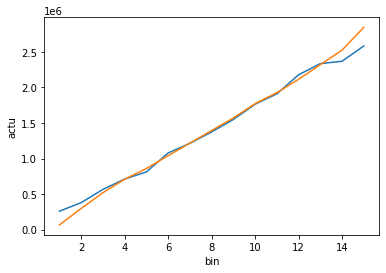

In [19]:
sns.lineplot(x = liftchart_df['bin'], y = liftchart_df['actu'])
sns.lineplot(x = liftchart_df['bin'], y = liftchart_df['pred'])
plt.show()

In [20]:
liftchart_df = get_liftchart_table(df['actu'], df['pred'], 15, df['years_at_risk'])

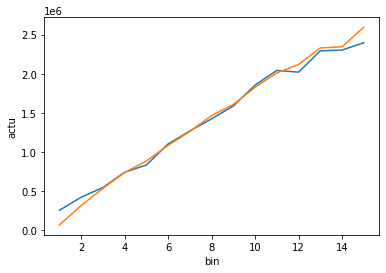

In [21]:
sns.lineplot(x = liftchart_df['bin'], y = liftchart_df['actu'])
sns.lineplot(x = liftchart_df['bin'], y = liftchart_df['pred'])
plt.show()